## 1.3.1 Max Flow Problem

Last week you figured out how to feed the Martian colonists. This week, your challenge is to provide
them with water. There are three bases that will need water: Kepler, Copernicus, and Tycho.
Two wells have been installed. There are five pipe intersections where water can be rerouted. The
pipes have specified capacities (in gallons/day) as seen in the network below:

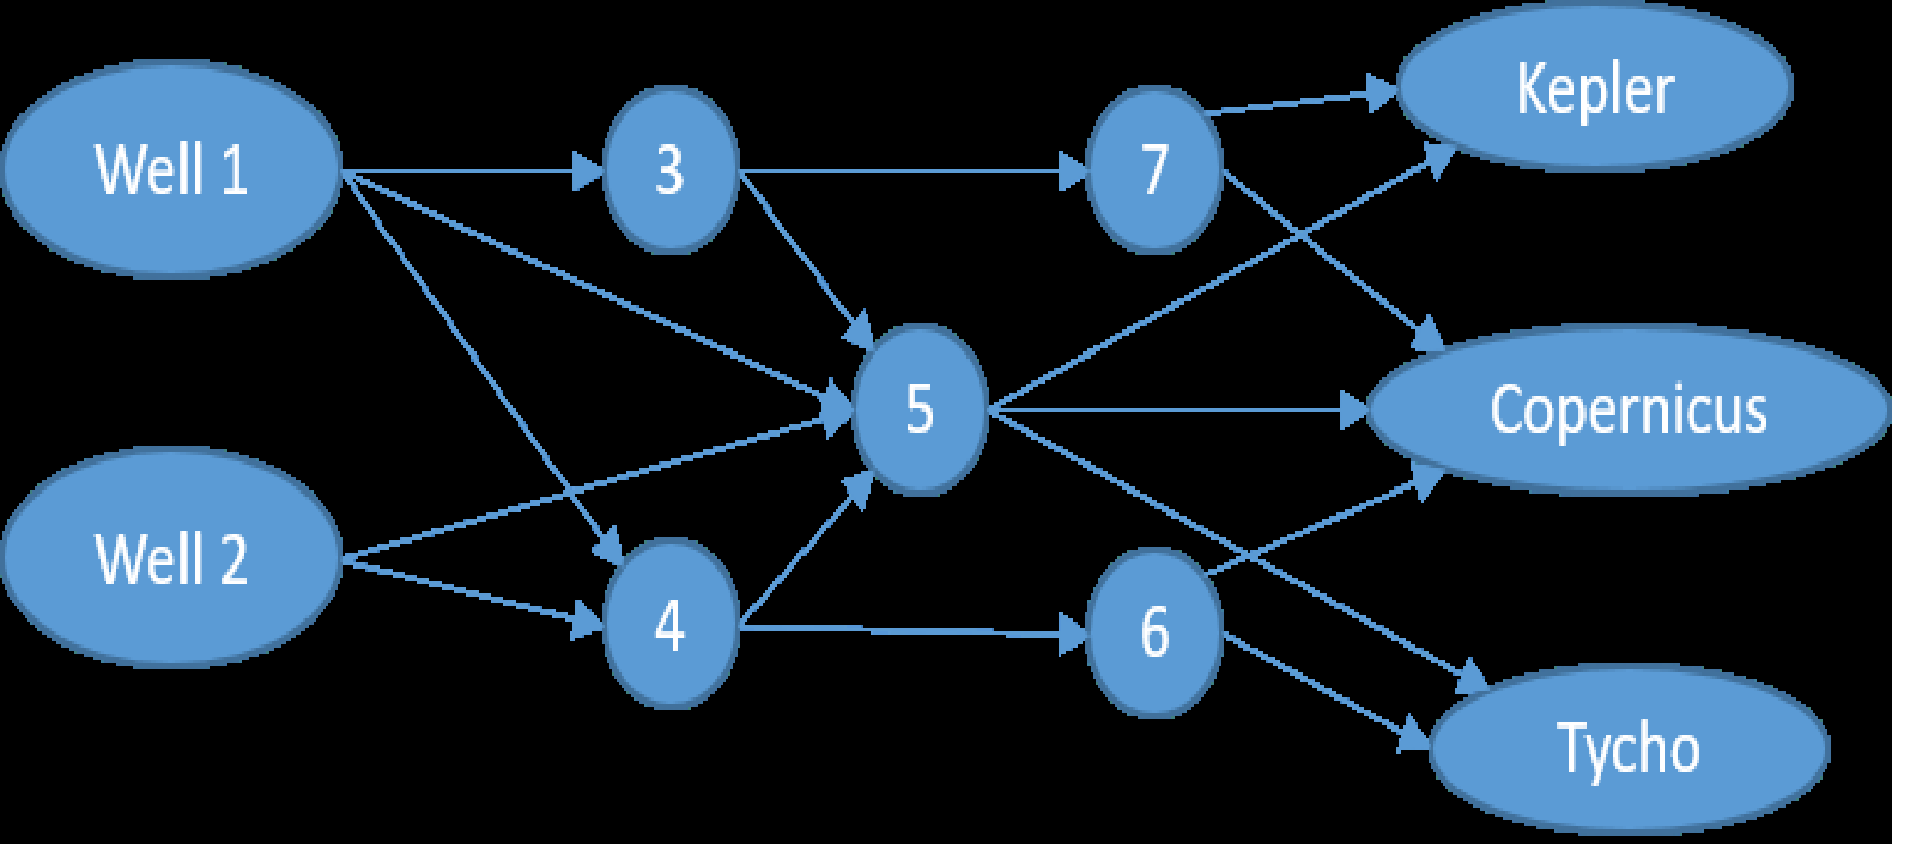

Well 1 can supply up to 30 gallons per day, andWell 2 can supply up to 27 gallons per day. Kepler
needs 17 gallons/day, Copernicus needs 15 gallons/day, and Tycho needs 21 gallons/day. What
is the maximum flow through the network? Can the daily demand be met?
Find a minimum cut in the network above.

### Answer
: This is a modified max flow problem. First, we will solve it as a typical max flow problem then modify as needed based on the solution.

In [8]:
using JuMP, Clp

# create a list of nodes. create a dummy source & sink.
nodes = [:s, :1, :2, :3, :4, :5, :6, :k, :c, :t, :si]

# create list of all arcs in the network. include dummy arc
# from the source to well 1 and well 2.
arcs = [(:s,:1), (:s,:2), (:1,:3), (:1, :4), (:1, :5), (:2,:4), (:2,:5), (:3,:5), (:3,:7),
(:4,:5), (:4,:6),(:5,:k),(:5,:c),(:5,:t),(:6,:c),(:6,:t),(7,:k),(:7,:c),(:k,:si),(:c,:si),(:t,:si), (:si,:s)]

# dictionary of arc capacities
capacity = Dict(zip(arcs,[30 27 21 11 16 22 5 16 9 2 23 14 10 16 10 9 8 10 100 100 100 100]))

m = Model(Clp.Optimizer)

# variables represent flow on each arc
@variable(m, x[arcs] >= 0)

# maximize total flow on arc from sink to source
@objective(m, Min, -x[(:si,:s)])

# obey capacity restrictions
@constraint(m, cap[a in arcs], x[a] <= capacity[a])

# balance flow on every node
@constraint(m, flow[i in nodes], sum(x[a] for a in arcs if a[1] == i) == sum(x[a] for a in arcs if a[2] == i))

# Tycho demand constraint
@constraint(m, x[(:t,:si)] >= 21) # >= okay too
# Kepler
@constraint(m, x[(:k,:si)] >= 17)
# Copernicus
@constraint(m, x[(:c,:si)] >= 15)

optimize!(m)

println("Total flow through network: ", -objective_value(m))

println("check if demand met: ")
println("flow to kepler (should be at least 17)", value(x[(:k,:si)]))
println("flow to copernicus (should be at least 15): ", value(x[(:c,:si)]))
println("flow to tycho (should be at least 21): ", value(x[(:t,:si)]))

Total flow through network: 56.0
check if demand met: 
flow to kepler (should be at least 17)20.0
flow to copernicus (should be at least 15): 15.0
flow to tycho (should be at least 21): 21.0
Coin0506I Presolve 7 (-29) rows, 14 (-8) columns and 28 (-38) elements
Clp0006I 0  Obj -43.6 Primal inf 42.799996 (5) Dual inf 3.999996 (4)
Clp0006I 7  Obj -56
Clp0000I Optimal - objective value -56
Coin0511I After Postsolve, objective -56, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective -56 - 7 iterations time 0.002, Presolve 0.00


 This model (max flow with three extra constraints) gives a feasible flow that meets demand!
 
 Now we need to find a minimum cut. Remmber that max flow = min cut, so we need to find a set
of arcs that separate the source from the sink such that the sum of the capacities on the arcs = 56.
We can use dual varaiable values to recover a minimum cut:

In [9]:
min_cut = 0
for a in arcs
    # if the dual variable is nonzero, the primal capacity constraint is active
    if abs(dual(cap[a])) > 10e-5
    # print the arc where the associated primal capacity is active
        println("Arc in cut: ", a, " Capacity: ", capacity[a], ")")
        min_cut = min_cut + capacity[a]
    end
end
println("Total capacity of this minimum cut (should be 56):", min_cut)

Arc in cut: (:s, 1) Capacity: 30)
Arc in cut: (2, 5) Capacity: 5)
Arc in cut: (4, 5) Capacity: 2)
Arc in cut: (6, :c) Capacity: 10)
Arc in cut: (6, :t) Capacity: 9)
Total capacity of this minimum cut (should be 56):56


### 1.10
Consider the following linear program:

\begin{align}
\max & 3x_1 + x_2\\
s.t. & 2x_1 + x_2 \leq 4\\
& 3x_1 + 2x_2 \geq 6\\
& 4x_1 + 2x_2 = 7\\
& x_1, x_2  free
\end{align}

(a) Find a solution to this linear program.

In [3]:
# First, just solve the original problem
using Clp, JuMP

m = Model(Clp.Optimizer)
set_optimizer_attribute(m,"LogLevel",0)

@variable(m, x1)
@variable(m, x2)

@objective(m, Max, 3 * x1 + x2)

@constraint(m, c1, 2 * x1 + x2 <= 4)
@constraint(m, c2, 3 * x1 + 2 * x2 >= 6)
@constraint(m, c3, 4 * x1 + 2 * x2 == 7)

optimize!(m)
println(m)
println("x1 = ", value(x1))
println("x2 = ", value(x2))
println(dual(c2))
println("objective = ", objective_value(m))

Max 3 x1 + x2
Subject to
 c3 : 4 x1 + 2 x2 == 7.0
 c2 : 3 x1 + 2 x2 >= 6.0
 c1 : 2 x1 + x2 <= 4.0

x1 = 1.0
x2 = 1.5
1.0
objective = 4.5


(b) Using the theorem of Complementary Slackness and the optimal primal solution, find the
optimal dual solution.

First, we can write the dual problem:

\begin{align}
\min &  4λ_1 + 6λ_2 + 7λ_3\\
s.t. & 2λ_1 + 3λ_2 + 4λ_3 = 3\\
& λ_1 + 2λ_2 + 2λ_3 = 1\\
& λ_1  \geq 0,  λ_2 \leq 0, λ_3 free\\
\end{align}

Because of strong duality, we know the dual object will also be 4.5. Let λ_i be the dual variable associated with constraints i = 1, 2, 3 in the primal problem.

First, we find which dual varaibles should be 0 by finding constraints with slack. Constraint 1 has 2(1)+1.5 = 2+1.5 < 4. In constraint 2, we have 3(1) + 2(1.5) = 6. Constraint 3 is an equality. Thus, only λ_1 = 0. We have equations and 2 unknowns, now, so let's take the objective and the first dual constraint and solve for λ_2 and λ_3.

\begin{align}
6λ_2 + 7λ_3 = 4.5\\
3λ_2 + 4λ_3 = 3\\
\end{align}

Solving for λ_2 and λ_3 leaves us with: λ = (0,−1, 1.5). We can double-check this gives us the right
objective by solving $4(0) + 6(-1) + 7(1.5) = 4.5

(c) How would our solution and objective value change if we increased the coefficient on x1 in
the objective to 5? What if we change the right-hand side on the 3rd constraint to 8?

In [3]:
using Clp, JuMP

# change primal cost

m = Model(Clp.Optimizer)
set_optimizer_attribute(m,"LogLevel",0)

@variable(m, x1)
@variable(m, x2)

@objective(m, Max, 5 * x1 + x2)

@constraint(m, c1, 2 * x1 + x2 <= 4)
@constraint(m, c2, 3 * x1 + 2 * x2 >= 6)
@constraint(m, c3, 4 * x1 + 2 * x2 == 7)

optimize!(m)

println("objective w/ changed primal cost = ", objective_value(m))
println()

# change primal constraint

m = Model(Clp.Optimizer)
set_optimizer_attribute(m,"LogLevel",0)

@variable(m, x1)
@variable(m, x2)

@objective(m, Max, 3 * x1 + x2)

@constraint(m, c1, 2 * x1 + x2 <= 4)
@constraint(m, c2, 3 * x1 + 2 * x2 >= 6)
@constraint(m, c3, 4 * x1 + 2 * x2 == 8)

optimize!(m)

println("objective w/ changed primal constraint = ", objective_value(m))

objective w/ changed primal cost = 6.5

objective w/ changed primal constraint = 6.0
